<a href="https://colab.research.google.com/github/evillag/TEC-ML-2022-1/blob/main/TP2/src_base/TP2_BayesianModel_MNIST_EVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

In [ ]:
%%capture
!wget https://github.com/evillag/TEC-ML-2022-1/raw/main/TP2/src_base/mnist_dataset.zip
!unzip /content/mnist_dataset.zip

train dimensions  torch.Size([784, 600])
train labels  600


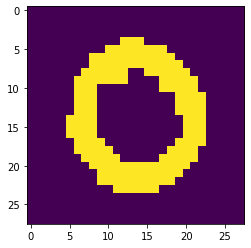

In [ ]:

def binarize_image(image_tensor):
    image_tensor[image_tensor > 0.5] = 1
    image_tensor[image_tensor <= 0.5] = 0
    return image_tensor

def load_dataset(path = "mnist_dataset/train"):
    #Open up the dataset
    dataset =  torchvision.datasets.ImageFolder(path)   
    #print(dataset)
    list_images = dataset.imgs
    #print(list_images)
    train_data_tensor  = None    
    labels_training = []
    first_tensor = True
    #list_images_training =  set(data_labeled.train_ds.x.items)
    #print(list_images)
    for i in range(0, len(list_images)):
        pair_path_label = list_images[i]        
        image = Image.open(pair_path_label[0]) 
        x_tensor = TF.to_tensor(image).squeeze()
        x_tensor_bin = binarize_image(x_tensor)

        x_tensor_bin_plain = x_tensor_bin.view(x_tensor_bin.shape[0] * x_tensor_bin.shape[1], -1)        
        #print("tensor ", x_tensor.shape)
        #test dataset case        
        #if("train" in pair_path_label[0]):
        labels_training += [pair_path_label[1]]
        # print(pair_path_label)
        if(first_tensor):
            plt.figure()
            plt.imshow(x_tensor_bin)
            first_tensor = False
            train_data_tensor = x_tensor_bin_plain
        else:
            train_data_tensor = torch.cat((train_data_tensor, x_tensor_bin_plain), 1)    
    return (train_data_tensor, torch.tensor(labels_training))       


(train_data_tensor, labels_training) = load_dataset(path = "/content/mnist_dataset/train")
print("train dimensions ", train_data_tensor.shape)
print("train labels ", len(labels_training))        
    


In [137]:
def test_model(input_torch, p_m_pix_val_given_k, p_t_tensor, num_classes = 10):
    #assumes that the input comes in a row
    #TODO IMPLEMENT
    #return (predicted_label, scores_classes)
    pass

def test_model_batch(test_set, labels, p_m_pix_val_given_k, p_t_tensor):
    return 0.0


def train_model(train_data_tensor, labels_training, num_classes = 10):
  p_m_0_given_k = torch.zeros(num_classes, train_data_tensor.shape[0])
  p_m_1_given_k = torch.ones(num_classes, train_data_tensor.shape[0])
  
  print(f'p_m_0_given_k shape {p_m_0_given_k.shape}')
  
  _, counts = torch.unique(labels_training, return_counts=True)
  p_t_tensor = counts / len(labels_training)

  for k in range(num_classes):
    training_indices_of_class_k = (labels_training == k).nonzero().squeeze(1)
    m = train_data_tensor[:, training_indices_of_class_k]

    # p(m = 0 | k) =>  (observations == 0) / (total observations of class k)
    p_m_0_given_k[k, :] = (m == 0.).sum(dim=1).div(m.shape[1])

  # calculate complement => p(m = 1 | k)
  p_m_1_given_k = p_m_1_given_k - p_m_0_given_k

  return [p_m_0_given_k, p_m_1_given_k], p_t_tensor
    



#(train_data_tensor, labels_training) = load_dataset()
#print("train dimensions ", train_data_tensor.shape)
#print("train labels ", len(labels_training))

#train model by calculating the prior probabilities
(p_m_pix_val_given_k, p_t_tensor) = train_model(train_data_tensor, labels_training)
print(f"p_m_pix_val_given_k[0] size {p_m_pix_val_given_k[0].shape}")
print(f"p_m_pix_val_given_k[1] size {p_m_pix_val_given_k[1].shape}")
print(f"p_t_tensor \n\tclasses: {p_t_tensor.shape}.\n\tValues: {p_t_tensor}")


# (predicted_label, scores_classes) = test_model(train_data_tensor[:, 500], p_m_pix_val_given_k, p_t_tensor)
# print("predicted_label ", predicted_label)
# print("real label ", labels_training[500])
# acc = test_model_batch(train_data_tensor, labels_training, p_m_pix_val_given_k, p_t_tensor)
# print("Model accuracy ", acc)
    


p_m_0_given_k shape torch.Size([10, 784])
Quick sample of a priori probabilities
tensor([1.0000, 0.9833, 0.9000, 0.8167, 0.7500, 0.6167, 0.5167, 0.5000, 0.5000,
        0.4833, 0.5167, 0.4833, 0.3833, 0.4000, 0.6000, 0.6667, 0.7167, 0.8167,
        0.9000, 0.9500, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9833, 0.9500, 0.8833, 0.8333, 0.7833, 0.6667, 0.6333, 0.6333,
        0.6667, 0.6500, 0.6333, 0.6167, 0.5000, 0.4333, 0.6000, 0.6833, 0.7167,
        0.8167, 0.8833, 0.9333, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9833, 0.9333, 0.9000, 0.8667, 0.8667, 0.8333, 0.8000,
        0.7833, 0.8167, 0.7833, 0.7833, 0.7167, 0.5833, 0.5333, 0.5667, 0.6500,
        0.7167, 0.8000, 0.9000, 0.9500, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9667, 0.9333, 0.9500, 0.8833, 0.8833,
        0.9000, 0.8833, 0.9333, 0.9000, 0.8500, 0.7000, 0.5833, 0.5333, 0.6000,
        0.6167])
tensor([0.0000, 0.0167

In [71]:
filtrado = (labels_training == 0).nonzero()
filtrado.squeeze(1).shape


torch.Size([60])

In [119]:
tensor_clase_k = train_data_tensor[:,filtrado]
print(f'shape filtrado {tensor_clase_k.shape}')

p_m_0_given_k = torch.zeros(10, train_data_tensor.shape[0])
print(f'p_m_0_given_k shape {p_m_0_given_k.shape}')
p_m_0_given_k[0,:] = (tensor_clase_k == 0.).sum(dim=1).div(tensor_clase_k.shape[1])
p_m_0_given_k[0,:]

shape filtrado torch.Size([784, 60])
p_m_0_given_k shape torch.Size([10, 784])


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9833, 0.9833,
        0.9833, 0.9500, 0.9833, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 